In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import binom

from qiskit import QuantumRegister, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

In [2]:
def create_circuit(n_step, n_depth, n_bath):
    n_wires = 2 + n_bath
    n_param = 2 * n_depth * n_step

    # circuit parameter storages
    param_data0 = ParameterVector('data_0', length=n_param)
    param_data1 = ParameterVector('data_1', length=n_param)
    param_bath = [ParameterVector(
        'bath_' + str(b), length=n_param) for b in range(n_bath)]

    q = QuantumRegister(n_wires, 'q')
    circuit = QuantumCircuit(q)

    for t in range(n_step):
        for d in range(n_depth):
            param_id = 2 * d + 2 * n_depth * t
            circuit.ry(param_data0[param_id], 0)
            circuit.rz(param_data0[param_id + 1], 0)
            circuit.ry(param_data1[param_id], 1)
            circuit.rz(param_data1[param_id + 1], 1)

            for b in range(n_bath):
                circuit.ry(param_bath[b][param_id], 2 + b)
                circuit.rz(param_bath[b][param_id + 1], 2 + b)

            circuit.cx(0, 1)

            for b in range(n_bath - 1):
                circuit.cx(2 + b, 2 + b + 1)

            circuit.cx(1, 2)

        if t < n_step - 1:
            for b in range(n_bath):
                circuit.reset(2 + b)

    return circuit

In [3]:
# helper functions
def Avg1stFP(dA, dB, t):
    dA2 = dA ** 2.0
    F_haar = 1. / binom(dA, dA - 1)
    res = F_haar * dA2 * (dB + 1) / (dA2 * dB + 1)
    res += (dA - 1) * (dA * dB - 1) / (dA2 * dB + 1) * \
        ((dA2 - 1) * dB / (dA2 * dB ** 2. - 1)) ** t

    return res

## $2+2$ Qubits, HEA circuit

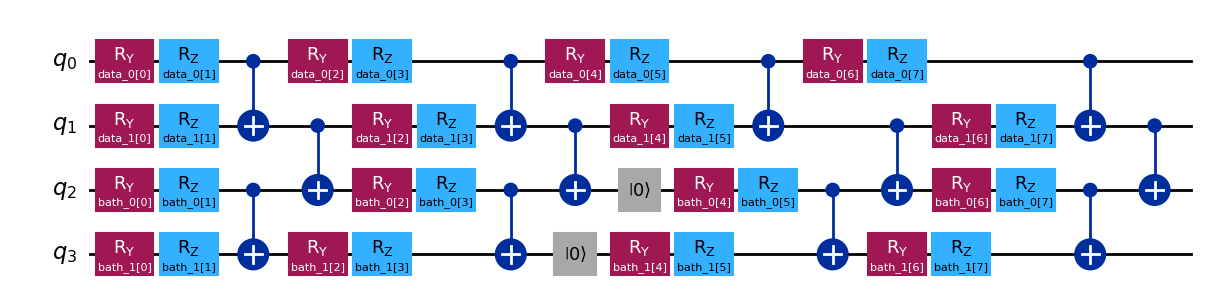

In [4]:
# plot a simple circuit
circuit = create_circuit(2, 2, 2)
circuit.draw('mpl')

In [ ]:
# setup backend and estimator
simulator = AerSimulator(method='density_matrix')
estimator = EstimatorV2(mode=simulator)

In [6]:
n_qubit = 4
pauli_op = ["I", "X", "Y", "Z"]
observables = [[Pauli('II' + q + p)] for p in pauli_op for q in pauli_op][1:]

In [7]:
# simple test run
n_batch = 5
n_step = 4
n_depth = 4
n_bath = 2

n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))

circuit = create_circuit(n_step, n_depth, n_bath)

pub = (circuit, observables, param_random)
job = estimator.run([pub])
r_vals = job.result()[0].data.evs
purity = (1. + (r_vals ** 2.).sum(0)) / 4.

[Avg1stFP(4, 4, n_step), purity.mean()]

[np.float64(0.3098142982004526), np.float64(0.31174436807632444)]

In [8]:
# noise-free simulation
n_batch = 1000
n_depth = 4
n_bath = 2

steps = [1, 2, 3, 5, 8]

purities = []
for n_step in steps:
    # setup the circuit
    n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))
    circuit = create_circuit(n_step, n_depth, n_bath)
    
    # feed a Primitive Unified Bloc to the estimator
    pub = (circuit, observables, param_random)
    job = estimator.run([pub])
    res = job.result()[0].data
    purity = (1. + (res.evs ** 2.).sum(0)) / 4.

    purities.append(purity)

purities = np.array(purities)

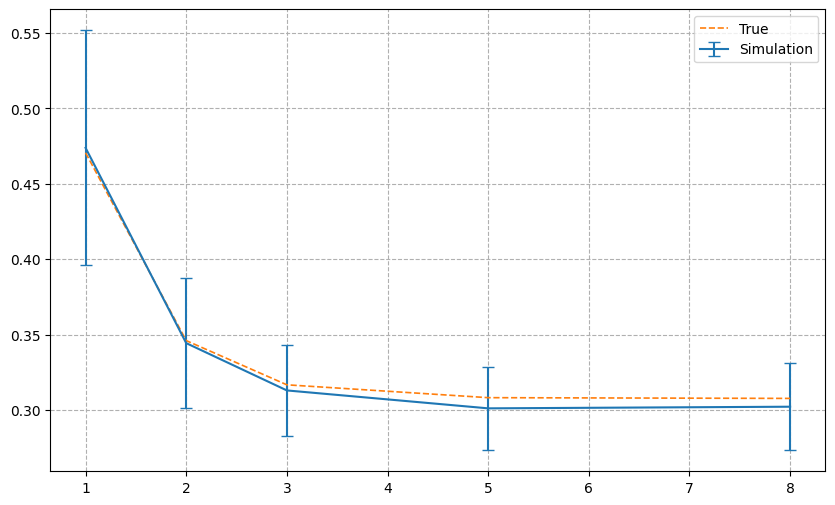

In [9]:
true_purities = [Avg1stFP(4, 4, t) for t in steps]
avg_purities = purities.mean(1)
std_purities = purities.std(1)

plt.figure(figsize=(10,6))
plt.errorbar(steps, avg_purities, yerr=std_purities, label='Simulation', capsize=4)
plt.plot(steps, true_purities, linewidth=1.2, linestyle='--', label='True')
plt.legend()
plt.grid(linestyle='--')

## $2+2$ Qubits, Noise Simulation

In [10]:
backend = FakeSherbrooke()
estimator = EstimatorV2(mode=backend)

In [11]:
n_batch = 500
n_depth = 4
n_bath = 2

steps = [1, 2, 3, 5, 8]

purities = []
for n_step in steps:
    n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
    param_random = np.random.uniform(0, 4. * np.pi, (n_batch, n_total_param))

    # must transpile the circuit for real/fake backend
    circuit = transpile(create_circuit(n_step, n_depth, n_bath), backend)

    # arragne observables based on transpiled circuit's layout
    observables = [[SparsePauliOp.from_sparse_list(
        [(q + p, [0, 1], 1.)], num_qubits=4).apply_layout(circuit.layout)] for p in pauli_op for q in pauli_op][1:]

    pub = (circuit, observables, param_random)
    job = estimator.run([pub])
    res = job.result()[0].data
    purity = (1. + (res.evs ** 2.).sum(0)) / 4.

    purities.append(purity)

purities = np.array(purities)

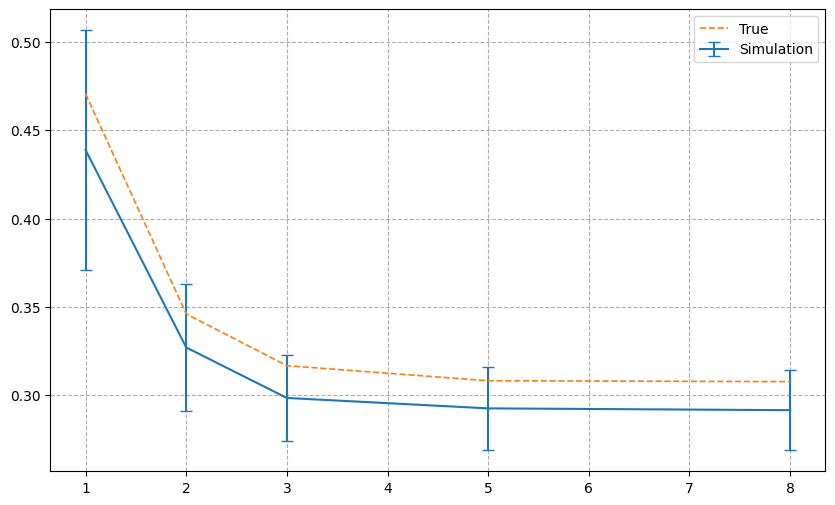

In [17]:
true_purities = [Avg1stFP(4, 4, t) for t in steps]
avg_purities = purities.mean(1)
std_purities = purities.std(1)

plt.figure(figsize=(10,6))
plt.errorbar(steps, avg_purities, yerr=std_purities, label='Simulation', capsize=4)
plt.plot(steps, true_purities, linewidth=1.2, linestyle='--', label='True')
plt.legend()
plt.grid(linestyle='--')

## $2+2$ Qubits, Noise from Real Device

In [ ]:
# instance, token = open('./api_token.txt','r').read().split()
# service = QiskitRuntimeService(
#     channel='ibm_quantum',
#     instance=instance,
#     token=token
# )
# backend = service.backend("ibm_sherbrooke")
# estimator = EstimatorV2(mode=backend)